#### <span style="color:#a50e3e;">Exercise 4: </span>  Use Deep Q Learning to solve an OpenAI Gym problem

In this exercise you will use a simulator provided by the popular [OpenAI Gym](https://gym.openai.com/) and perform Deep Q-Learning to learn an optimal control law for a particular problem (called an      Environment) there.  You can learn how to install and get started using the gym by examining the [appropriate documentation](https://gym.openai.com/docs/). 

The syntax for initializing and updating any simulator in the gym mirrors that used for gridworld in the previous problem.  That is to initialize any of the simulators you use the following command

```
state = simulator.reset()
```

and to take a step (based on a permittable action) you likewise use the command

```
next_state, reward, done, info = simulator.step(action)
```

Solve the problems listed at the end of the [course notes](https://www.dropbox.com/s/xsmkjgswelu2f4v/Q_to_deepQ_notes_SLIDES.pdf?dl=0) using Deep Q Learning, that is


- the [cartpole problem](https://gym.openai.com/envs/CartPole-v1/) 


- the [lunar lander problem](https://gym.openai.com/envs/LunarLander-v2/)


Here 'solved' means being able to accomplished the stated goal for each task as listed on their introductory pages above.  

Note a few technical points about your final implementation:

- **Defining your network:** For this exercise you can use Python, PyTorch, or Keras / Tensorflow to define / update your network architectures.  A pure-Python network builder - the one used to perform multi-output regression in the [course notes](https://www.dropbox.com/s/xsmkjgswelu2f4v/Q_to_deepQ_notes_SLIDES.pdf?dl=0) is shown in the included file `pure_python_multi_output_func_scratch.ipynb` in the `pure_python_architecture_examples` subdirectory.  You can see an example of how to build a network architecture using PyTorch or Tensorflow - using the cartpole problem as a test simulator - in tutorials like [this one for PyTorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) or [this one for Tensorflow](https://keon.io/deep-q-learning/) (note in the former case a convnet is being used, you need only use a multilayer perceptron for these exercises).  *Note:* do not simply copy and paste one of these tutorials for your submission!  If you use a tutorial like one of these as a base for your own development work thats fine, but make sure to actually understand, digest, and re-organize it as detailed in class.


- **Network structure:** You shouldn't need too deep a network for either of these problems.  In our experiments a two or three layer fully connected network with less than 100 units per layer worked fine (along with pretty much any activation).


- **Reward structure:** Examine the reward structure of these problems carefully, and make any ad-hoc changes to them.  For example, if the difference in reward between 'good' and 'bad' states is small numerically speaking, you can feel free to re-define these rewards in your Q-Learning loop


- **Other parameters:** Typically speaking you need not worry much about the short-term / long-term parameter, and it can be set to $\gamma = 1$ (or something close like $\gamma = 0.99$) for your entire training run.  The exploitation / exploration parameter can be set small - to a value like $0.1$ or even $0.01$ - for all iterations, or you can decrease it from $1$ to a small number like $0.1$ as your training progresses.  For the sake of simplicity, in both of the examples shown in the course notes we just kept this parameter fixed to $0.1$ for the entire training run.  Each of our runs took less than 1000 episodes of training for $Q$ to resolve well.

In [20]:
import sys
sys.path.append('../')
import autograd.numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

from keras.layers import Dense
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)


class Agent:
    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.action_samples = []
        self.state_samples = []
        self.next_state_samples = []
        self.reward_samples = []
        self.done_samples = []
        self.Q = self.build_model(state_size,action_size)
        self.p = 1
        self.gamma = 0.99
        self.memory_size = 1000
        self.p_min = 0.01
        self.p_decay_rate = 0.995
        
    def create_io_pairs(self,batch_size):
        #  take  a  sample  of  tuples  from  replay  memory
        #self.sample_memory()
        #  generate  values  to  regress  on  based  on  most  recent  Q
        q_vals=[]
        idx_sample = np.random.choice(len(self.action_samples),batch_size,replace=False)
        #print(idx_sample)
        state_fit = []
        for i in idx_sample:
            #  grab  tuple  of  data
            state=self.state_samples[i]
            state_fit.append(state)
            next_state=self.next_state_samples[i]
            reward=self.reward_samples[i]
            done=self.done_samples[i]
            action=self.action_samples[i]
            #  compute  and  store  q  outputs  for  regression
            q=reward
            if done==False:
                qs=self.Q.predict(next_state)[0]
                q+=self.gamma*np.max(qs)
            #  clamp  all  other  models  to  their  current  values  
            #  for  this  input/output  pair
            #  by  creating  phantom  outputs
            q_update=self.Q.predict(state)[0]
            q_update[action]=q
            q_vals.append(q_update)
            q_update = np.reshape(q_update, [1, self.action_size])
        self.Q.fit(np.reshape(np.array(state_fit),[batch_size,self.state_size]),np.reshape(np.array(q_vals),[batch_size,self.action_size]),batch_size=batch_size,epochs=1,verbose=0) 
        # TRIAL
        #self.action_samples = []
        #self.state_samples = []
        #self.next_state_samples = []
        #self.reward_samples = []
        #self.done_samples = []
            #self.Q.fit(state,q_update,epochs=1,verbose=0) 
        return(q_vals)
    
    def sample_memory(self):
        
        return
    def update(self,batch_size):
        #  don't  regress  unless  sufficient  tuples  have  been  created
        if len(self.action_samples)<batch_size:
            return
        q_vals=self.create_io_pairs(batch_size)
        if self.p>self.p_min:
            self.p=self.p*self.p_decay_rate
        return
    
    #  choose  next  action
    def choose_action(self,state):
        r=np.random.rand(1)
        if r>self.p:
            #  choose action based on Q (exploit)
            action=np.argmax(self.Q.predict(state)[0])
        else:
            #  choose random action (explore)
            action=np.random.randint(self.action_size)
        return action
    
    def remember(self,state,next_state,action,reward,done):
        if len(self.action_samples)>=self.memory_size:
            self.state_samples.pop(0)
            self.next_state_samples.pop(0)
            self.action_samples.pop(0)
            self.reward_samples.pop(0)
            self.done_samples.pop(0)
        self.state_samples.append(state)
        self.next_state_samples.append(next_state)
        self.action_samples.append(action)
        self.reward_samples.append(reward)
        self.done_samples.append(done)
        return
    
    def build_model(self,x_size,y_size,**kwargs):
        # default parameters for network
        layer_sizes = [100,100]      # two hidden layers, 100 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        # changed loss for lunar lander
        loss = 'mse'
        optimizer = Adam(lr = 10**(-3),decay=10**(-6),clipnorm=1)        

        # input / output sizes of network
        input_dim = x_size
        output_dim = y_size

        # build model based on parameters
        model = Sequential()

        # add input layer
        model.add(Dense(layer_sizes[0], input_dim=input_dim, activation=activation))

        # add hidden layers
        for U in layer_sizes[1:]:
            model.add(Dense(U,activation=activation))

        # add output layer
        model.add(Dense(output_dim, activation='softmax'))

        # chose optimizer and its associated parameters
        #model.summary()   # print out summary of network structure
        model.compile(loss=loss, optimizer=optimizer)
        return model
    
import matplotlib.pyplot as plt
from matplotlib import gridspec

#### compare cost function histories ####
def plot_cost_history(cost_history,start):        
    # initialize figure
    fig = plt.figure(figsize = (10,3))

    # create subplot with 1 panel
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0]); 

    # plot train cost function history
    ax.plot(np.arange(start,len(cost_history),1),cost_history[start:],linewidth = 3*(0.8)**(1),label = 'reward') 

    # clean up panel / axes labels
    xlabel = 'step $k$'
    ylabel = 'reward'
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14,rotation = 0,labelpad = 25)

    # plot legend
    anchor = (1,1)
    plt.legend(loc='upper right', bbox_to_anchor=anchor)
    ax.set_xlim([start - 0.5,len(cost_history) - 0.5]) 
    plt.show()


def plot_reward_history(data,**kwargs):
    # load in total episode reward history
    #data = np.loadtxt(logname)
    ave = [data[v] for v in range(100)]
    
    for i in range(0,np.size(data)-100):
        m = np.mean(data[i:i+100])
        ave.append(m)
    
    # create figure
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot total reward history
    start = 0
    if 'start' in kwargs:
        start = kwargs['start']
    ax1.plot(data[start:])
    ax1.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax1.set_ylabel('total reward',fontsize = 13)
    
    ax2.plot(ave[start:],linewidth=3)
    ax2.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax2.set_ylabel('ave total reward',fontsize=13)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import gym
import copy
simulator = gym.make('LunarLander-v2')
state_size = 8
action_size = 4
episodes = 1000
batch_size = 1024
#  start  episode  simulation
episode_rewards=np.zeros((episodes,1))
agent = Agent(state_size,action_size)
agent.p=0.1
agent.gamma=1
agent.memory_size = 10000
agent.p_decay_rate = 1
#count_total = np.zeros((episodes,1))
for e in range(episodes):
    state = simulator.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    #counter = 0
    done=False
    while done==False:
        #  choose  next  action
        action=agent.choose_action(state)
        #  transition  to  next  state,  get  associated  reward
        next_state,reward,done,info=simulator.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        #  update  Q  function
        # only remember better runs
        agent.remember(state,next_state,action,reward,done)
        
        #  update  total  reward  from  this  episode
        total_reward+=reward
        #counter  = counter + 1
        state=copy.deepcopy(next_state)
    # try updating after each episode
    agent.update(batch_size)
    episode_rewards[e]=total_reward
    print("Episode "+str(e)+", reward: "+str(episode_rewards[e]))

/home/joele119/Desktop/ml_class/Reinforce_hw_2_w_examples/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 0, reward: [-231.47036434]
Episode 1, reward: [-159.49985341]
Episode 2, reward: [-151.26729402]
Episode 3, reward: [-156.91096348]
Episode 4, reward: [-254.00585846]
Episode 5, reward: [-190.78597089]
Episode 6, reward: [-106.33390116]
Episode 7, reward: [-184.21301811]
Episode 8, reward: [-147.20089005]
Episode 9, reward: [-173.68322082]
Episode 10, reward: [-173.25098087]
Episode 11, reward: [-162.72235268]
Episode 12, reward: [-271.14584328]
Episode 13, reward: [-276.40463746]
Episode 14, reward: [-574.84346203]
Episode 15, reward: [-576.60068794]
Episode 16, reward: [-722.61087716]
Episode 17, reward: [-729.69363784]
Episode 18, reward: [-523.9004077]
Episode 19, reward: [-68.39751518]
Episode 20, reward: [-48.27653326]
Episode 21, reward: [-343.83460947]
Episode 22, reward: [-289.72022334]
Episode 23, reward: [-529.71273952]
Episode 24, reward: [-382.51346655]
Episode 25, re

Episode 219, reward: [-172.75070146]
Episode 220, reward: [-335.00529149]
Episode 221, reward: [-313.24773551]
Episode 222, reward: [-130.76078495]
Episode 223, reward: [-176.42895155]
Episode 224, reward: [-373.31147361]
Episode 225, reward: [-297.16179636]
Episode 226, reward: [-394.19368883]
Episode 227, reward: [-349.46313093]
Episode 228, reward: [-436.56620406]
Episode 229, reward: [-97.53209821]
Episode 230, reward: [-216.27221196]
Episode 231, reward: [-166.86911884]
Episode 232, reward: [-115.10267007]
Episode 233, reward: [-332.13048369]
Episode 234, reward: [-246.62370781]
Episode 235, reward: [-258.69913197]
Episode 236, reward: [-249.20941313]
Episode 237, reward: [-327.14199394]
Episode 238, reward: [-286.61450504]
Episode 239, reward: [-290.66300472]
Episode 240, reward: [-91.1807423]
Episode 241, reward: [-282.17087607]
Episode 242, reward: [-347.48087522]
Episode 243, reward: [-260.0149332]
Episode 244, reward: [-368.93894278]
Episode 245, reward: [-233.82418895]
Episo

Episode 442, reward: [-304.66186178]
Episode 443, reward: [-238.74530435]
Episode 444, reward: [-307.48822757]
Episode 445, reward: [-173.90041689]
Episode 446, reward: [-290.33440713]
Episode 447, reward: [-246.94605548]
Episode 448, reward: [-155.01991451]
Episode 449, reward: [-255.31562947]
Episode 450, reward: [-213.76767869]
Episode 451, reward: [-52.5623017]
Episode 452, reward: [-258.29403097]
Episode 453, reward: [143.33388832]
Episode 454, reward: [-271.9294398]
Episode 455, reward: [-48.41995749]
Episode 456, reward: [-143.15476412]
Episode 457, reward: [-245.59099003]
Episode 458, reward: [-112.80971282]
Episode 459, reward: [-173.5129102]
Episode 460, reward: [-125.70546356]
Episode 461, reward: [-122.08647317]
Episode 462, reward: [-141.11688718]
Episode 463, reward: [-388.00622074]
Episode 464, reward: [-300.07213163]
Episode 465, reward: [-448.62626026]
Episode 466, reward: [-361.3910806]
Episode 467, reward: [-174.7198533]
Episode 468, reward: [-88.65446371]
Episode 46

Episode 666, reward: [-117.83557813]
Episode 667, reward: [-370.3645714]
Episode 668, reward: [-341.23335536]
Episode 669, reward: [-232.25050218]
Episode 670, reward: [-186.5558723]
Episode 671, reward: [-118.99558608]
Episode 672, reward: [-125.82223379]
Episode 673, reward: [-298.23345002]
Episode 674, reward: [-373.67856794]
Episode 675, reward: [-314.83649316]
Episode 676, reward: [-309.85915048]
Episode 677, reward: [-278.98046877]
Episode 678, reward: [-374.75414547]
Episode 679, reward: [-328.36184424]
Episode 680, reward: [-284.26469265]
Episode 681, reward: [-587.62862224]
Episode 682, reward: [-504.36511837]
Episode 683, reward: [-481.85010734]
Episode 684, reward: [-196.92008725]
Episode 685, reward: [-509.85152647]
Episode 686, reward: [-243.25240177]
Episode 687, reward: [-338.58239147]
Episode 688, reward: [-346.09753476]
Episode 689, reward: [-649.32675591]
Episode 690, reward: [-453.40667217]
Episode 691, reward: [-347.15221115]
Episode 692, reward: [-333.24549984]
Epi

Episode 889, reward: [-363.20550005]
Episode 890, reward: [254.47143805]
Episode 891, reward: [-277.90357957]
Episode 892, reward: [-247.63787523]
Episode 893, reward: [-276.05980311]
Episode 894, reward: [-339.08215435]
Episode 895, reward: [-134.99704674]
Episode 896, reward: [-350.20804414]
Episode 897, reward: [-323.83068804]
Episode 898, reward: [-97.40311955]
Episode 899, reward: [-198.52618667]
Episode 900, reward: [-179.61160005]
Episode 901, reward: [-362.12242373]
Episode 902, reward: [-141.27946438]
Episode 903, reward: [-242.50789315]
Episode 904, reward: [-333.57054843]
Episode 905, reward: [-107.31816055]
Episode 906, reward: [-324.84888448]
Episode 907, reward: [-281.62703977]
Episode 908, reward: [-308.92268112]
Episode 909, reward: [-315.73003447]
Episode 910, reward: [-315.27621468]
Episode 911, reward: [-294.82245851]
Episode 912, reward: [-114.6336095]
Episode 913, reward: [-258.89946565]
Episode 914, reward: [-192.78758784]
Episode 915, reward: [-51.04812723]
Episo

<IPython.core.display.Javascript object>


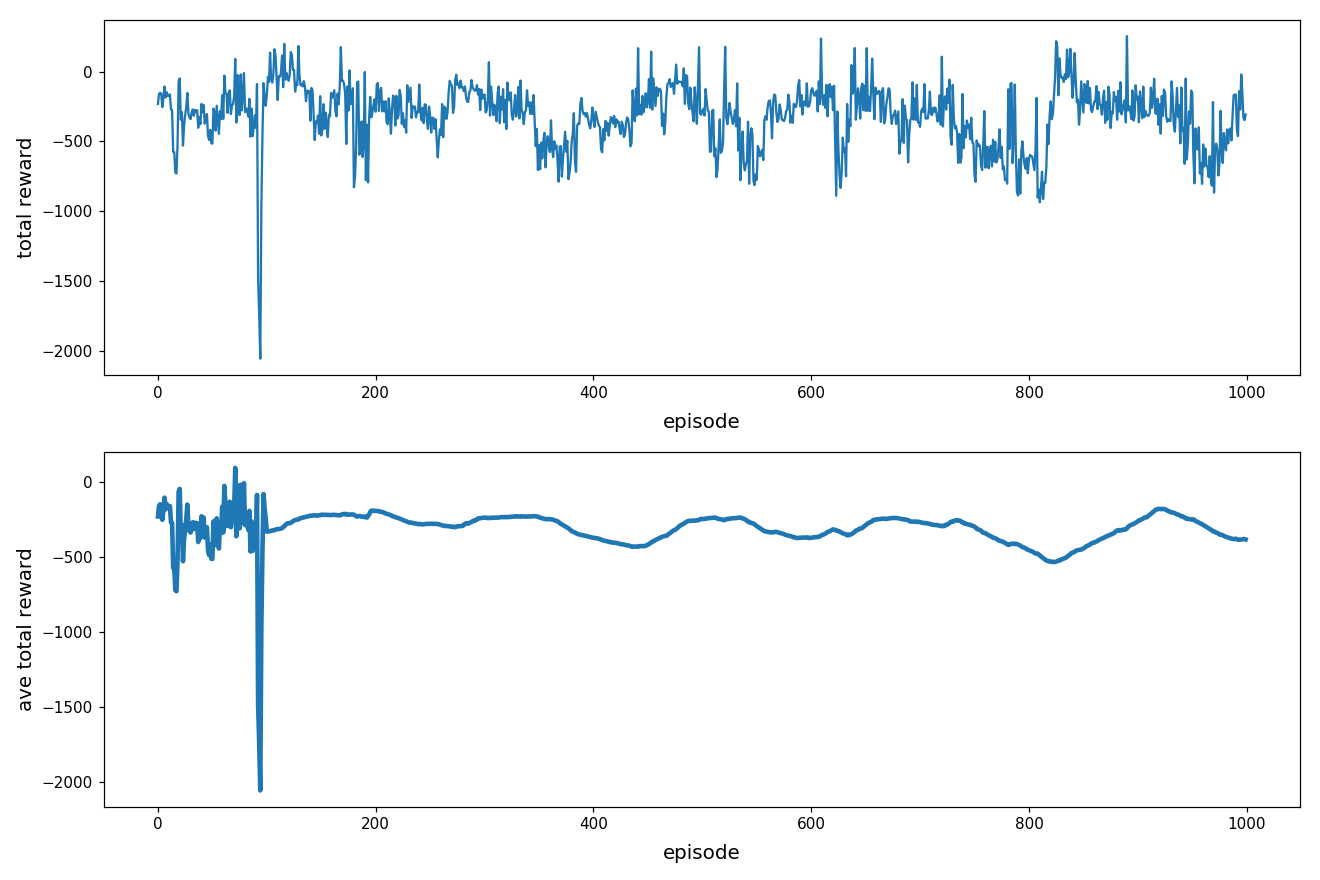

In [22]:
plot_reward_history(episode_rewards)

#### I wasn't able to get better than this training after doing a lot of different layer sizes, number of layers, exploration/exploitation decay rates, learning rates, batch sizes, memory sizes and initial exploration/exploitation parameter. Additionally, I tried using the logcosh loss (the closest thing that Keras has to the Huber loss). I'm not really sure what the best way to do this is - however, here, I've tried using a very large batch size and memory, along with relatively low exploration. I've also tried clipping the norm of the gradient to 1, to prevent overstepping when doing gradient descent. It's not above 200 (not even close), but I have no idea how to get it closer.